# Description

This project analyzes sales data for Cable Prime to support a sales consultant's presentation to the Head of Sales. The analysis includes data preparation, descriptive and diagnostic insights, sales forecasting, and strategic recommendations. The goal is to understand current sales performance, diagnose underlying factors, forecast next year's sales, and provide actionable strategies to achieve 150% sales growth. Additionally, a plan is outlined for monthly analysis using efficient tools and technologies.

In [45]:
# To start working with the dataset, we will import the following libraries

import pandas as pd  # Pandas for data manipulation and analysis
import numpy as np   # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for basic data visualization
import seaborn as sns  # Seaborn for advanced data visualization
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
import warnings  # Warnings to suppress unnecessary warnings
warnings.filterwarnings("ignore")

## Loading the date into our environment

In [18]:
# Read the Excel file
cable_prime = pd.read_excel('CablePrimeDataSet.xlsx')

# Display the head of the dataframe
cable_prime.head()

,PaymentAmount,PaymentDate,CustomerIdentifier,PaymentMethod,Gender,Race,Province,ProductID,Age
0,$107,20190623,81246587.0,Debit Order,Female,Black,North West,269424.0,32
1,$53,20190623,82087789.0,Debit Order,Female,Black,Gauteng,685715.0,48
2,$171,20190623,115560640.0,Debit Order,Male,White,Gauteng,523463.0,64
3,$42,20190623,87506111.0,Debit Order,Female,Asian,Free State,420110.0,27
4,$53,20190623,114356637.0,Debit Order,Female,NaN,Gauteng,761379.0,35


## Understanding the Data

In [4]:
cable_prime.dtypes

PaymentAmount          object
PaymentDate             int64
CustomerIdentifier    float64
PaymentMethod          object
Gender                 object
Race                   object
Province               object
ProductID             float64
Age                     int64
dtype: object

In [5]:
cable_prime.shape

(584008, 9)

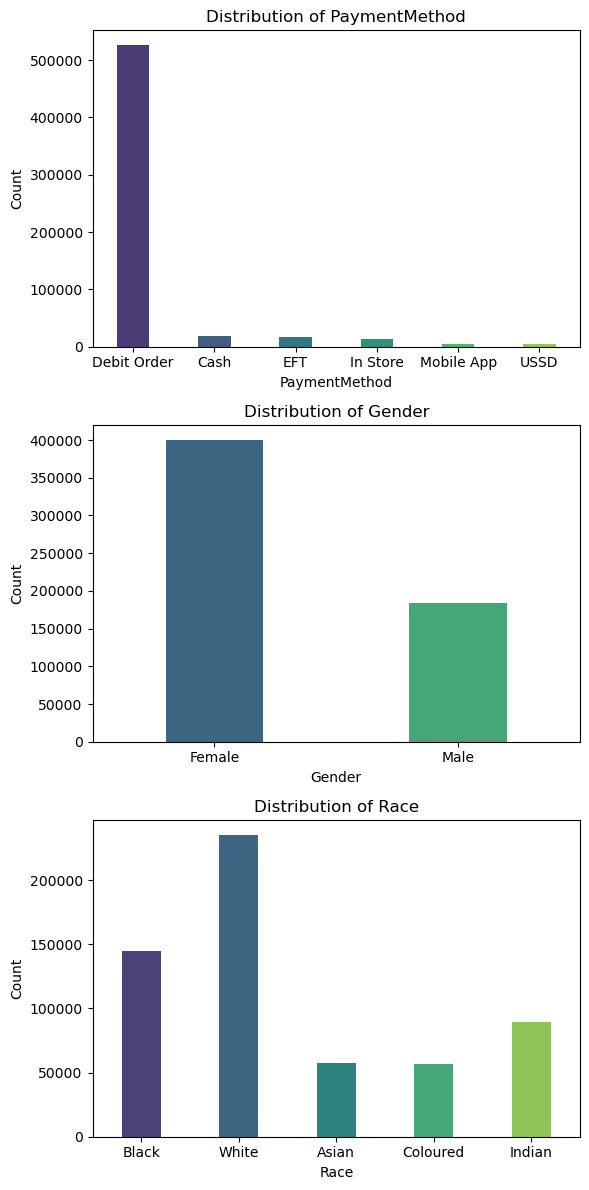

In [6]:
# The Dataset containing the categorical columns
parameters = ['PaymentMethod', 'Gender', 'Race']

# Create subplots for each parameter
fig, axes = plt.subplots(nrows=len(parameters), ncols=1, figsize=(6, 4 * len(parameters)))

# Specify the bar width
bar_width = 0.4

for i, param in enumerate(parameters):
    sns.countplot(x=param, data=cable_prime, palette='viridis', ax=axes[i], width=bar_width)
    axes[i].set_title(f'Distribution of {param}')
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

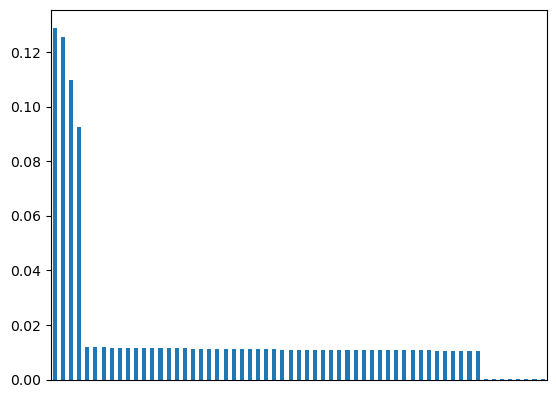

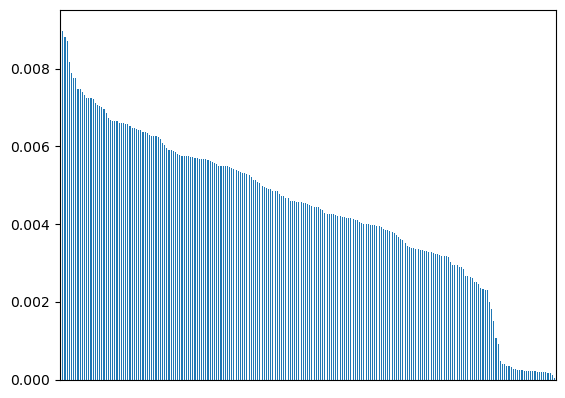

In [7]:
# Now let's visualize the ordinal variables.

# Plotting 'Age'
cable_prime['Age'].value_counts(normalize=True).plot.bar()
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

# Plotting 'PaymentDate'
cable_prime['PaymentDate'].value_counts(normalize=True).plot.bar()
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()


## Cleaning the Data

In [19]:
# Missing Values in the dataset
missing_values = cable_prime.isnull().sum()
print(missing_values)

PaymentAmount            0
PaymentDate              0
CustomerIdentifier       1
PaymentMethod         1219
Gender                  51
Race                   785
Province                21
ProductID                1
Age                      0
dtype: int64


In [20]:
# Remove extra spaces from column names
cable_prime.columns = cable_prime.columns.str.strip()


In [21]:
# Remove dollar sign and space from 'PaymentAmount' column

cable_prime['PaymentAmount'] = cable_prime['PaymentAmount'].str.replace('$', '').str.replace(' ', '')

# cable_prime['PaymentAmount'] = cable_prime['PaymentAmount'].apply(lambda x: str(x).strip().replace('$', ''))

In [22]:
# Convert 'PaymentAmount' from object to float
cable_prime['PaymentAmount'] = pd.to_numeric(cable_prime['PaymentAmount'], errors='coerce')

In [23]:
# Dropping rows with missing values can lead to a substantial loss of information.
# Hence we will fill missing values in categorical columns with the mode (most frequent value) 
# and in numerical columns with the median

# Fill missing values for numerical columns with the median
cable_prime['CustomerIdentifier'].fillna(cable_prime['CustomerIdentifier'].median(), inplace=True)
cable_prime['ProductID'].fillna(cable_prime['ProductID'].median(), inplace=True)

# Fill missing values for categorical columns with the mode
cable_prime['PaymentMethod'].fillna(cable_prime['PaymentMethod'].mode()[0], inplace=True)
cable_prime['Gender'].fillna(cable_prime['Gender'].mode()[0], inplace=True)
cable_prime['Race'].fillna(cable_prime['Race'].mode()[0], inplace=True)
cable_prime['Province'].fillna(cable_prime['Province'].mode()[0], inplace=True)


# Display the cleaned DataFrame
cable_prime.head(10)

,PaymentAmount,PaymentDate,CustomerIdentifier,PaymentMethod,Gender,Race,Province,ProductID,Age
0,107,20190623,81246587.0,Debit Order,Female,Black,North West,269424.0,32
1,53,20190623,82087789.0,Debit Order,Female,Black,Gauteng,685715.0,48
2,171,20190623,115560640.0,Debit Order,Male,White,Gauteng,523463.0,64
3,42,20190623,87506111.0,Debit Order,Female,Asian,Free State,420110.0,27
4,53,20190623,114356637.0,Debit Order,Female,White,Gauteng,761379.0,35
5,107,20190623,79957164.0,Debit Order,Female,White,N/E/W Cape,523463.0,23
6,221,20190623,80991237.0,Debit Order,Female,Coloured,Kwazulu Natal,269424.0,41
7,192,20190623,114179634.0,Debit Order,Male,White,Gauteng,32384.0,69
8,171,20190623,85097727.0,Debit Order,Female,Black,Mpumalanga,269424.0,58
9,85,20190623,103729286.0,Debit Order,Male,Black,Gauteng,420110.0,44


In [24]:
# Next we Convert the 'Payment Date' column to a consistent date format.

# Convert 'PaymentDate' to datetime format
cable_prime['PaymentDate'] = pd.to_datetime(cable_prime['PaymentDate'], format='%Y%m%d')

# Verify the conversion
cable_prime['PaymentDate'].head()

0   2019-06-23
1   2019-06-23
2   2019-06-23
3   2019-06-23
4   2019-06-23
Name: PaymentDate, dtype: datetime64[ns]

In [25]:
# Define functions to detect and handle outliers
def detect_outliers(series, threshold=3):
    z_scores = (series - series.mean()) / series.std()
    return z_scores.abs() > threshold

def remove_outliers(df, columns, threshold=3):
    for col in columns:
        outliers = detect_outliers(df[col], threshold)
        df = df[~outliers]
    return df

# Define criteria for outlier removal (e.g., for numeric columns)
numeric_columns = ['PaymentAmount', 'PaymentDate', 'CustomerIdentifier', 'ProductID', 'Age']
cable_prime = remove_outliers(cable_prime, numeric_columns)

## Analyzing the Data

In [26]:
from tabulate import tabulate

# Print summary statistics after data validation
print("After data validation:")
print(tabulate(cable_prime.describe(), headers='keys', tablefmt='psql'))

After data validation:
+-------+-----------------+-------------------------------+----------------------+-------------+-------------+
|       |   PaymentAmount | PaymentDate                   |   CustomerIdentifier |   ProductID |         Age |
|-------+-----------------+-------------------------------+----------------------+-------------+-------------|
| count |     583588      | 583588                        |     583588           |      583588 | 583588      |
| mean  |        119.732  | 2019-04-13 19:57:34.121743360 |          9.92211e+07 |      406155 |     40.894  |
| min   |         27      | 2019-01-02 00:00:00           |          5.48401e+07 |       32384 |      3      |
| 25%   |         85      | 2019-02-25 00:00:00           |          8.41377e+07 |      269424 |     30      |
| 50%   |        101      | 2019-04-13 00:00:00           |          1.0427e+08  |      523463 |     41      |
| 75%   |        171      | 2019-06-04 00:00:00           |          1.14438e+08 |      5

### Descriptive Analytics

Mean Payment Amount: $119.73
Median Payment Amount: $101.00


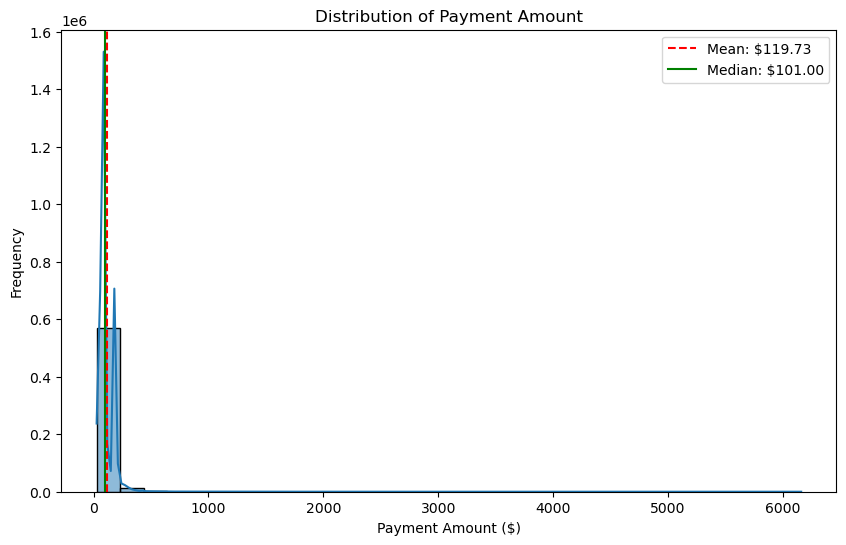

In [27]:
# Payment Amount: This code snalyzes the distribution, mean, and median to understand average sales.

# Calculate and print mean and median
mean_payment = cable_prime['PaymentAmount'].mean()
median_payment = cable_prime['PaymentAmount'].median()

print(f"Mean Payment Amount: ${mean_payment:.2f}")
print(f"Median Payment Amount: ${median_payment:.2f}")

# Plot the distribution of PaymentAmount
plt.figure(figsize=(10, 6))
sns.histplot(cable_prime['PaymentAmount'], kde=True, bins=30)
plt.title('Distribution of Payment Amount')
plt.xlabel('Payment Amount ($)')
plt.ylabel('Frequency')
plt.axvline(mean_payment, color='r', linestyle='--', label=f'Mean: ${mean_payment:.2f}')
plt.axvline(median_payment, color='g', linestyle='-', label=f'Median: ${median_payment:.2f}')
plt.legend()
plt.show()

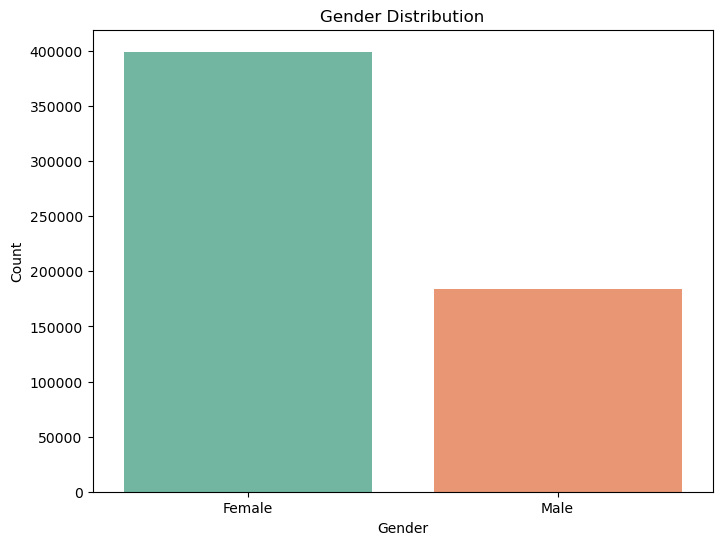

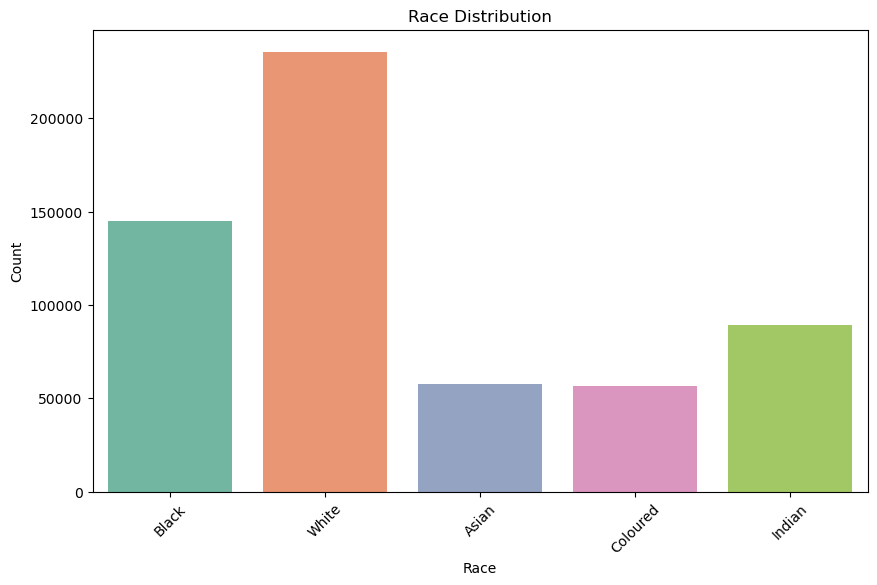

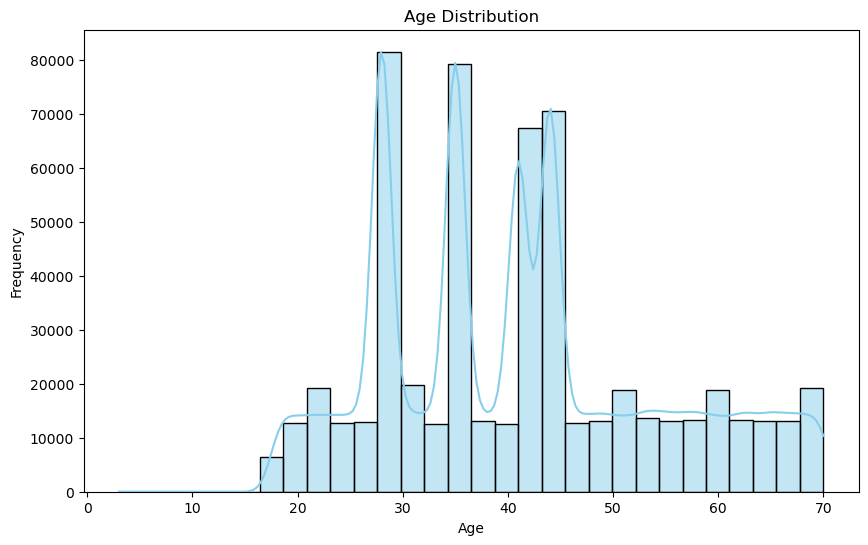

In [28]:
# Customer Demographics: Here we Examine the distribution of Gender, Race, and Age to identify customer segments

# Gender Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=cable_prime, x='Gender', palette='Set2')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Race Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=cable_prime, x='Race', palette='Set2')
plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(cable_prime['Age'], kde=True, bins=30, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


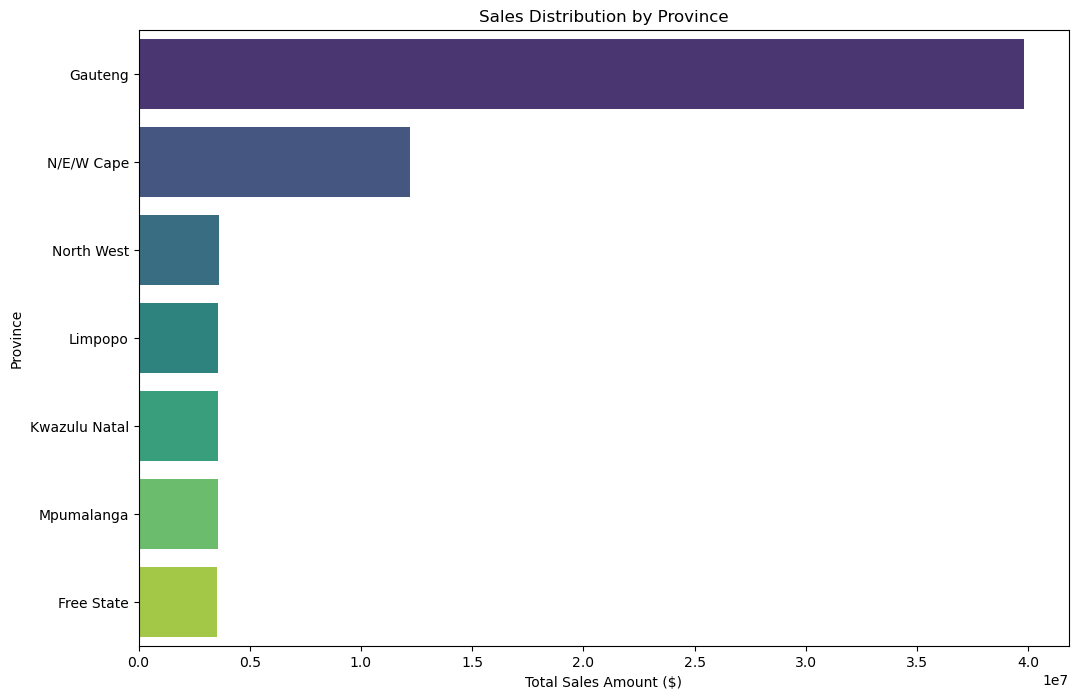

Sales by Province:
        Province  PaymentAmount
1        Gauteng       39815943
5     N/E/W Cape       12210060
6     North West        3613081
3        Limpopo        3594132
2  Kwazulu Natal        3560538
4     Mpumalanga        3556670
0     Free State        3523848


In [29]:
# Geographical Insights: This code Analyzes sales distribution by Province to identify key markets.

# Group by Province and calculate the sum of PaymentAmount
province_sales = cable_prime.groupby('Province')['PaymentAmount'].sum().reset_index()

# Sort the data by PaymentAmount in descending order
province_sales = province_sales.sort_values(by='PaymentAmount', ascending=False)

# Plot the sales distribution by Province
plt.figure(figsize=(12, 8))
sns.barplot(data=province_sales, x='PaymentAmount', y='Province', palette='viridis')
plt.title('Sales Distribution by Province')
plt.xlabel('Total Sales Amount ($)')
plt.ylabel('Province')
plt.show()

# Print summary statistics for sales by Province
print("Sales by Province:")
print(province_sales)

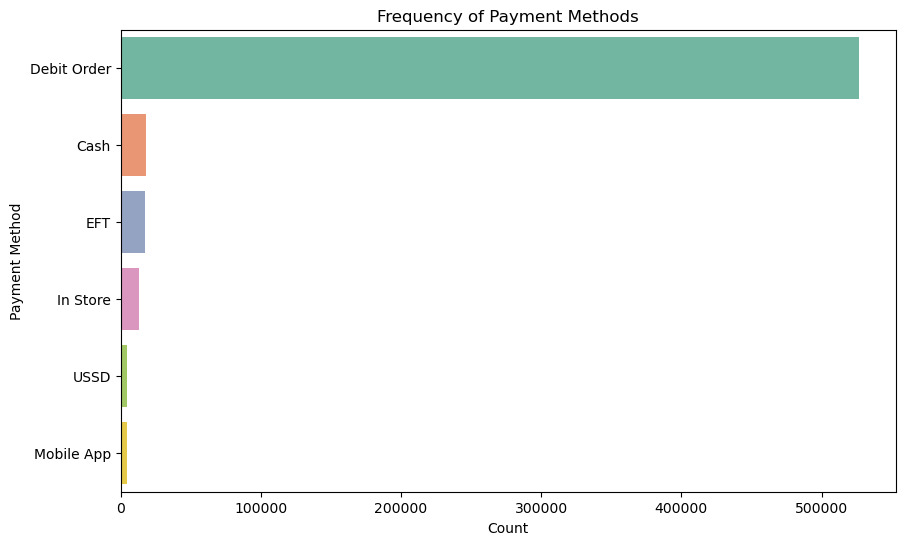

Frequency of Payment Methods:
  PaymentMethod   Count
0   Debit Order  526564
1          Cash   17954
2           EFT   17521
3      In Store   12928
4          USSD    4435
5    Mobile App    4186


In [30]:
# Payment Methods: Here we Analyze the frequency of different PaymentMethods to understand customer preferences

# Calculate the frequency of each payment method
payment_method_counts = cable_prime['PaymentMethod'].value_counts().reset_index()
payment_method_counts.columns = ['PaymentMethod', 'Count']

# Plot the frequency of each payment method
plt.figure(figsize=(10, 6))
sns.barplot(data=payment_method_counts, x='Count', y='PaymentMethod', palette='Set2')
plt.title('Frequency of Payment Methods')
plt.xlabel('Count')
plt.ylabel('Payment Method')
plt.show()

# Print the frequency of each payment method
print("Frequency of Payment Methods:")
print(payment_method_counts)


In [31]:
# Create a DataFrame for the product information
product_info = pd.DataFrame({
    'ProductID': [523463, 32384, 761379, 685715, 269424, 420110, 617164, 844702, 590836],
    'Product': ['CableMax', 'CableMobi', 'CableMini', 'CableMov', 'CableSport', 'CableKids', 'CableSun', 'CableWeekender', 'CableTravel'],
    'ProductDescription': [
        'All inclusive connection on all devices all shows 247',
        'Mobile only connection 247 all shows',
        'Selection of entertainment 247',
        'Movie entertainment available 247 all devices',
        'Sport entertainment available 247',
        'Kids entertainment available 247',
        'All entertainment on Sundays only',
        'All entertainment Fri to Sun',
        'CableMobi with Download functionality'
    ]
})

# Merge the product_info DataFrame with the cable_prime DataFrame
cable_prime = cable_prime.merge(product_info, on='ProductID', how='left')

# Print the updated DataFrame to verify the changes
cable_prime.head()

,PaymentAmount,PaymentDate,CustomerIdentifier,PaymentMethod,Gender,Race,Province,ProductID,Age,Product,ProductDescription
0,107,2019-06-23,81246587.0,Debit Order,Female,Black,North West,269424.0,32,CableSport,Sport entertainment available 247
1,53,2019-06-23,82087789.0,Debit Order,Female,Black,Gauteng,685715.0,48,CableMov,Movie entertainment available 247 all devices
2,171,2019-06-23,115560640.0,Debit Order,Male,White,Gauteng,523463.0,64,CableMax,All inclusive connection on all devices all sh...
3,42,2019-06-23,87506111.0,Debit Order,Female,Asian,Free State,420110.0,27,CableKids,Kids entertainment available 247
4,53,2019-06-23,114356637.0,Debit Order,Female,White,Gauteng,761379.0,35,CableMini,Selection of entertainment 247


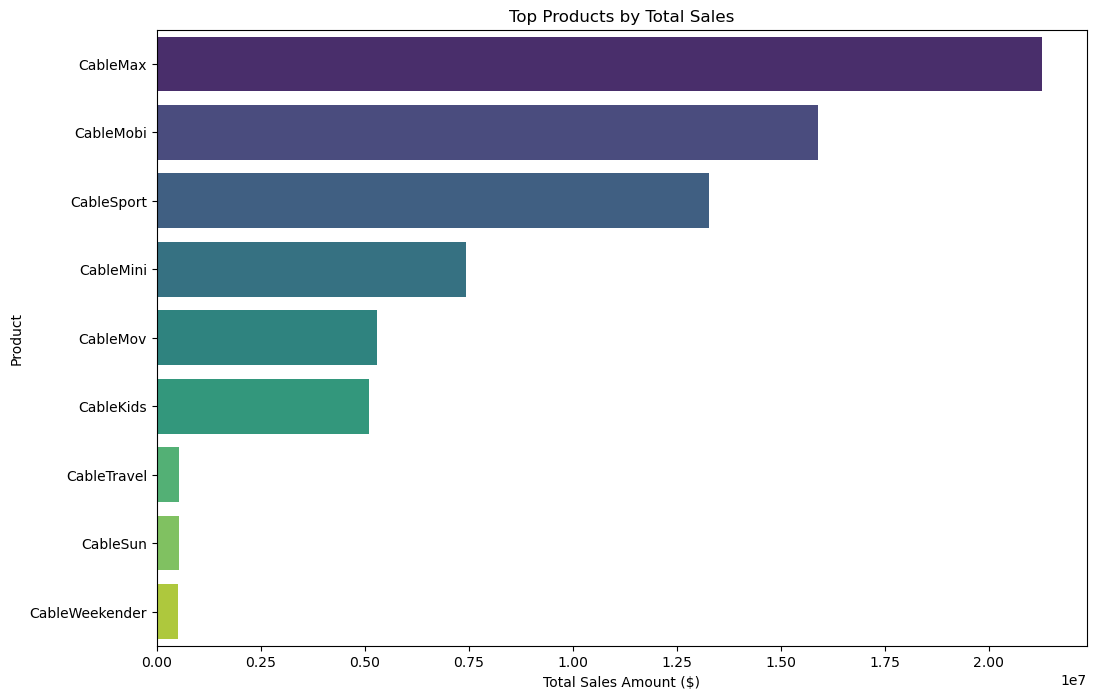

Top Products by Total Sales:
          Product  PaymentAmount
1        CableMax       21292307
3       CableMobi       15891481
5      CableSport       13280953
2       CableMini        7433940
4        CableMov        5295126
0       CableKids        5099524
7     CableTravel         535851
6        CableSun         535544
8  CableWeekender         509546


In [32]:
# 1. Top Products by Total Sales
top_products_sales = cable_prime.groupby('Product')['PaymentAmount'].sum().reset_index()
top_products_sales = top_products_sales.sort_values(by='PaymentAmount', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_products_sales, x='PaymentAmount', y='Product', palette='viridis')
plt.title('Top Products by Total Sales')
plt.xlabel('Total Sales Amount ($)')
plt.ylabel('Product')
plt.show()

# Print the top products by total sales
print("Top Products by Total Sales:")
print(top_products_sales)

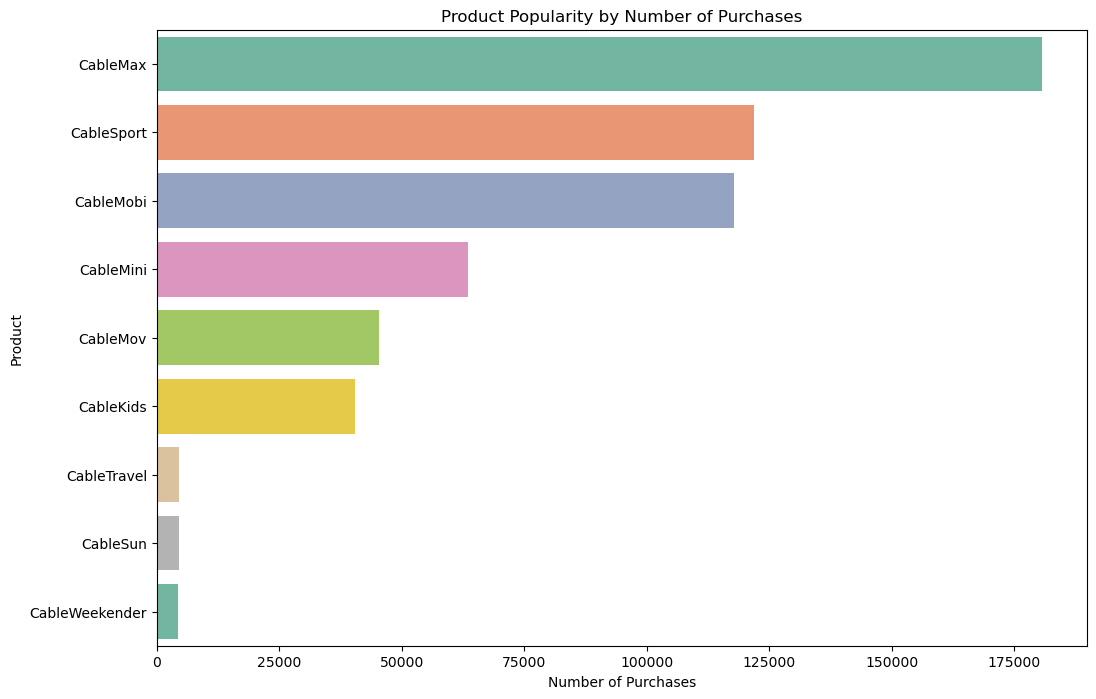

Product Popularity by Number of Purchases:
          Product   Count
0        CableMax  180805
1      CableSport  121957
2       CableMobi  117933
3       CableMini   63585
4        CableMov   45326
5       CableKids   40532
6     CableTravel    4534
7        CableSun    4510
8  CableWeekender    4406


In [33]:
# 2. Product Popularity (Number of Purchases)
product_popularity = cable_prime['Product'].value_counts().reset_index()
product_popularity.columns = ['Product', 'Count']
product_popularity = product_popularity.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=product_popularity, x='Count', y='Product', palette='Set2')
plt.title('Product Popularity by Number of Purchases')
plt.xlabel('Number of Purchases')
plt.ylabel('Product')
plt.show()

# Print the product popularity
print("Product Popularity by Number of Purchases:")
print(product_popularity)

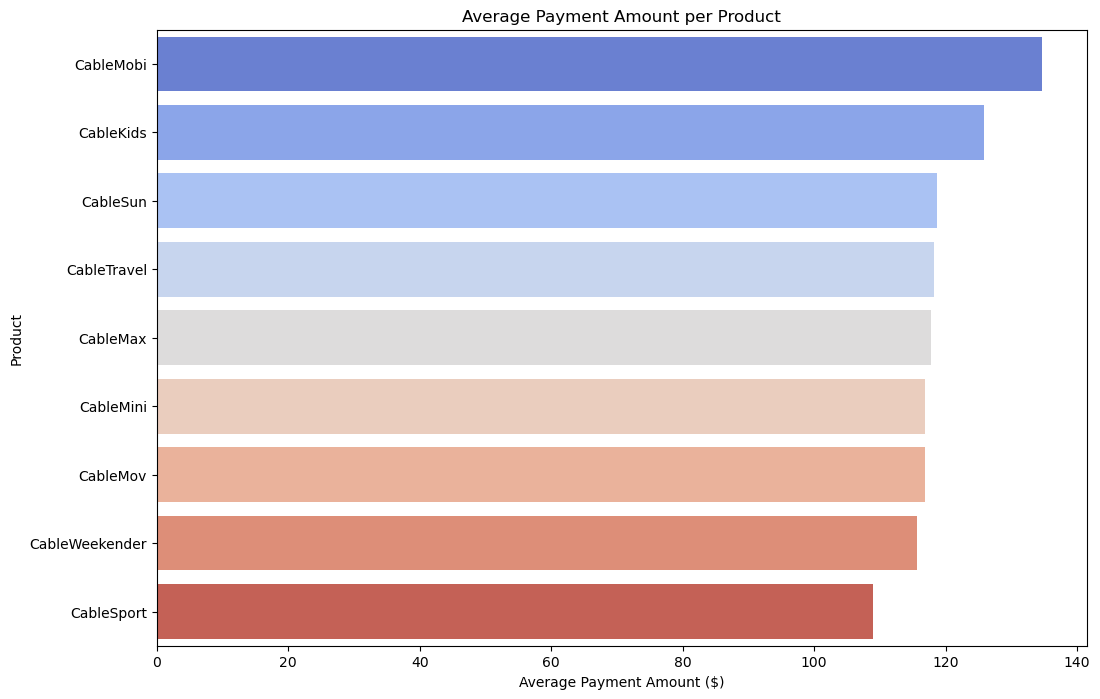

Average Payment Amount per Product:
          Product  PaymentAmount
3       CableMobi     134.750078
0       CableKids     125.814764
6        CableSun     118.745898
7     CableTravel     118.185046
1        CableMax     117.763928
2       CableMini     116.913423
4        CableMov     116.823148
8  CableWeekender     115.648207
5      CableSport     108.898653


In [34]:
# 3. Average Payment Amount per Product
average_payment_per_product = cable_prime.groupby('Product')['PaymentAmount'].mean().reset_index()
average_payment_per_product = average_payment_per_product.sort_values(by='PaymentAmount', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=average_payment_per_product, x='PaymentAmount', y='Product', palette='coolwarm')
plt.title('Average Payment Amount per Product')
plt.xlabel('Average Payment Amount ($)')
plt.ylabel('Product')
plt.show()

# Print the average payment amount per product
print("Average Payment Amount per Product:")
print(average_payment_per_product)

### Diagnostic Analysis

Correlation between PaymentAmount and Age: -0.03


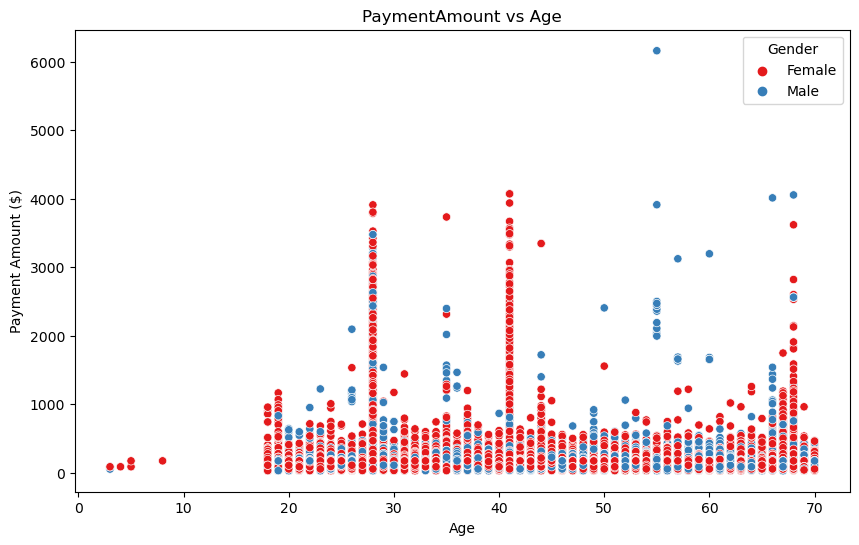

In [35]:
# Correlation Analysis: Exploring relationships between PaymentAmount and variables like Age, Gender,
# Province, and Product.

# 1. Correlation between PaymentAmount and Age
correlation_age = cable_prime['PaymentAmount'].corr(cable_prime['Age'])
print(f"Correlation between PaymentAmount and Age: {correlation_age:.2f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cable_prime, x='Age', y='PaymentAmount', hue='Gender', palette='Set1')
plt.title('PaymentAmount vs Age')
plt.xlabel('Age')
plt.ylabel('Payment Amount ($)')
plt.show()

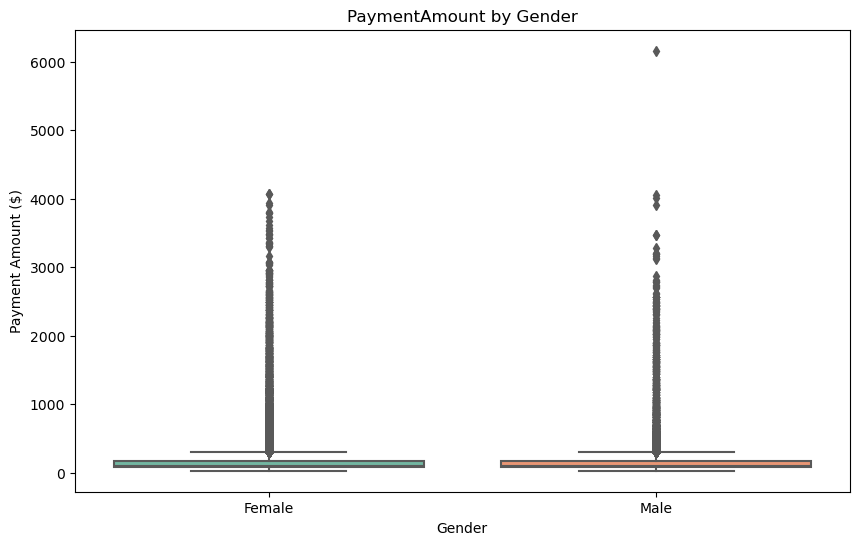

In [36]:
# 2. PaymentAmount by Gender
plt.figure(figsize=(10, 6))
sns.boxplot(data=cable_prime, x='Gender', y='PaymentAmount', palette='Set2')
plt.title('PaymentAmount by Gender')
plt.xlabel('Gender')
plt.ylabel('Payment Amount ($)')
plt.show()

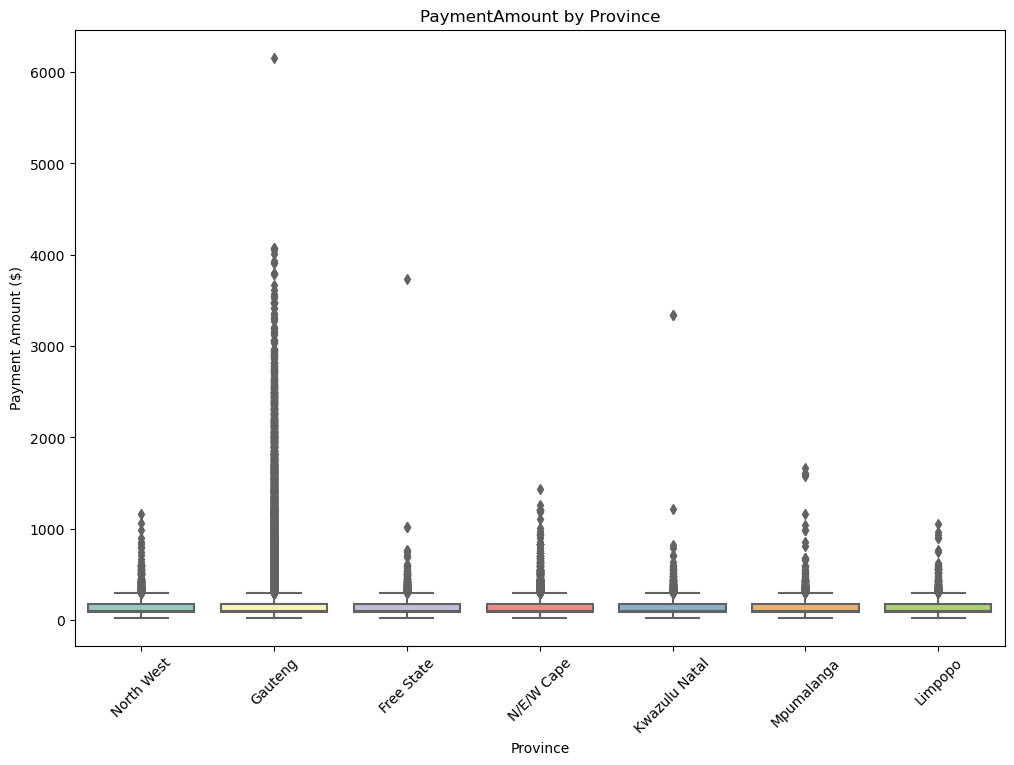

In [37]:
# 3. PaymentAmount by Province
plt.figure(figsize=(12, 8))
sns.boxplot(data=cable_prime, x='Province', y='PaymentAmount', palette='Set3')
plt.title('PaymentAmount by Province')
plt.xlabel('Province')
plt.ylabel('Payment Amount ($)')
plt.xticks(rotation=45)
plt.show()

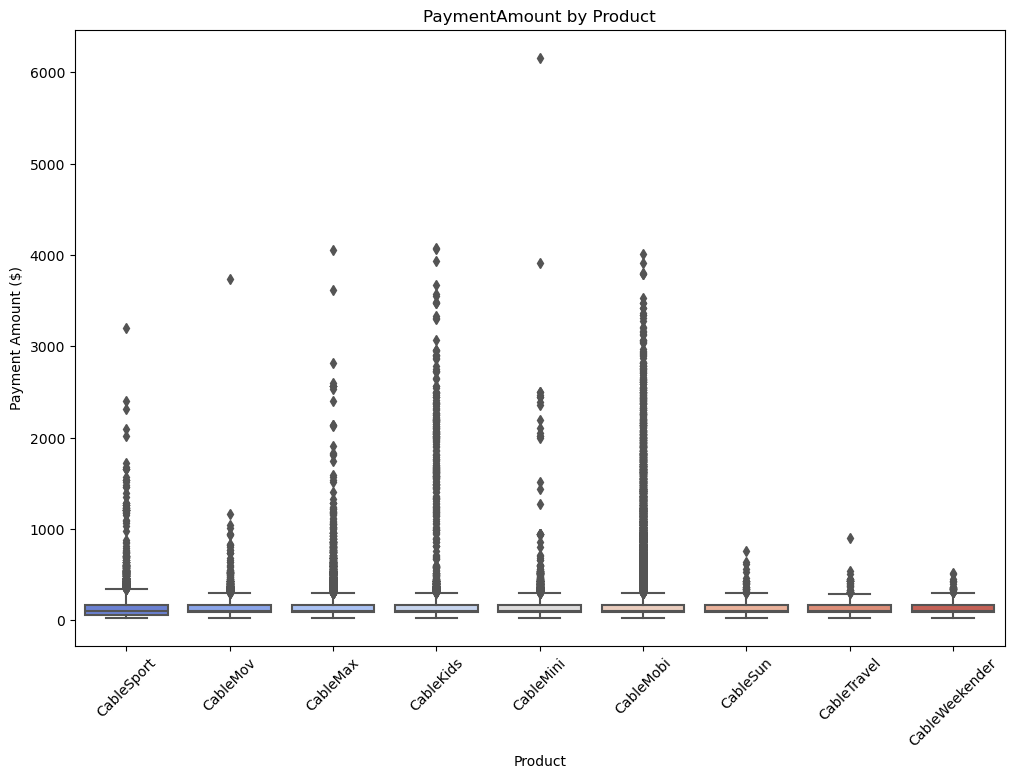

In [38]:
# 4. PaymentAmount by Product
plt.figure(figsize=(12, 8))
sns.boxplot(data=cable_prime, x='Product', y='PaymentAmount', palette='coolwarm')
plt.title('PaymentAmount by Product')
plt.xlabel('Product')
plt.ylabel('Payment Amount ($)')
plt.xticks(rotation=45)
plt.show()

In [40]:
# Trend Analysis: Analyzing sales trends over time using the PaymentDate to identify any 
# seasonality or patterns.

# 1. Create time-based features
cable_prime['Year'] = cable_prime['PaymentDate'].dt.year
cable_prime['Month'] = cable_prime['PaymentDate'].dt.month
cable_prime['Day'] = cable_prime['PaymentDate'].dt.day


In [41]:
# 2. Aggregate sales data over time
# Aggregate by month and year to identify monthly trends
monthly_sales = cable_prime.groupby(['Year', 'Month'])['PaymentAmount'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(Day=1))

# Aggregate by year to identify yearly trends
yearly_sales = cable_prime.groupby('Year')['PaymentAmount'].sum().reset_index()

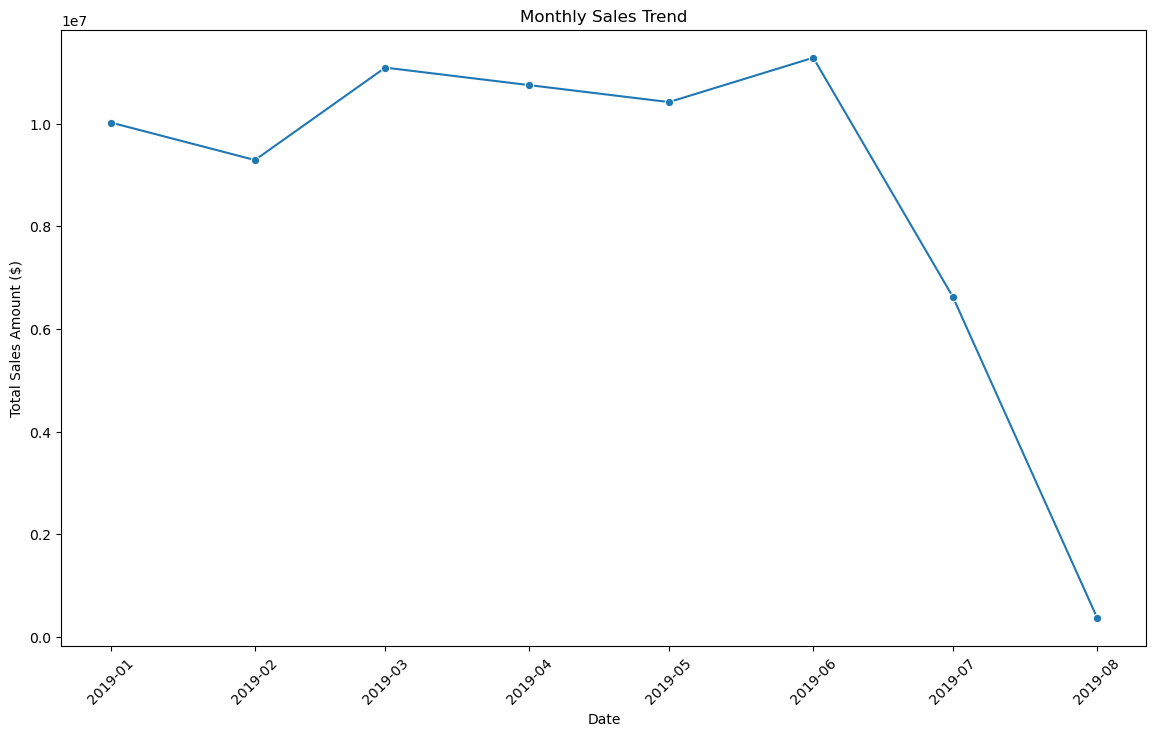

In [43]:
# 3. Visualize trends
# Monthly Sales Trend
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_sales, x='Date', y='PaymentAmount', marker='o', palette='viridis')
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount ($)')
plt.xticks(rotation=45)
plt.show()


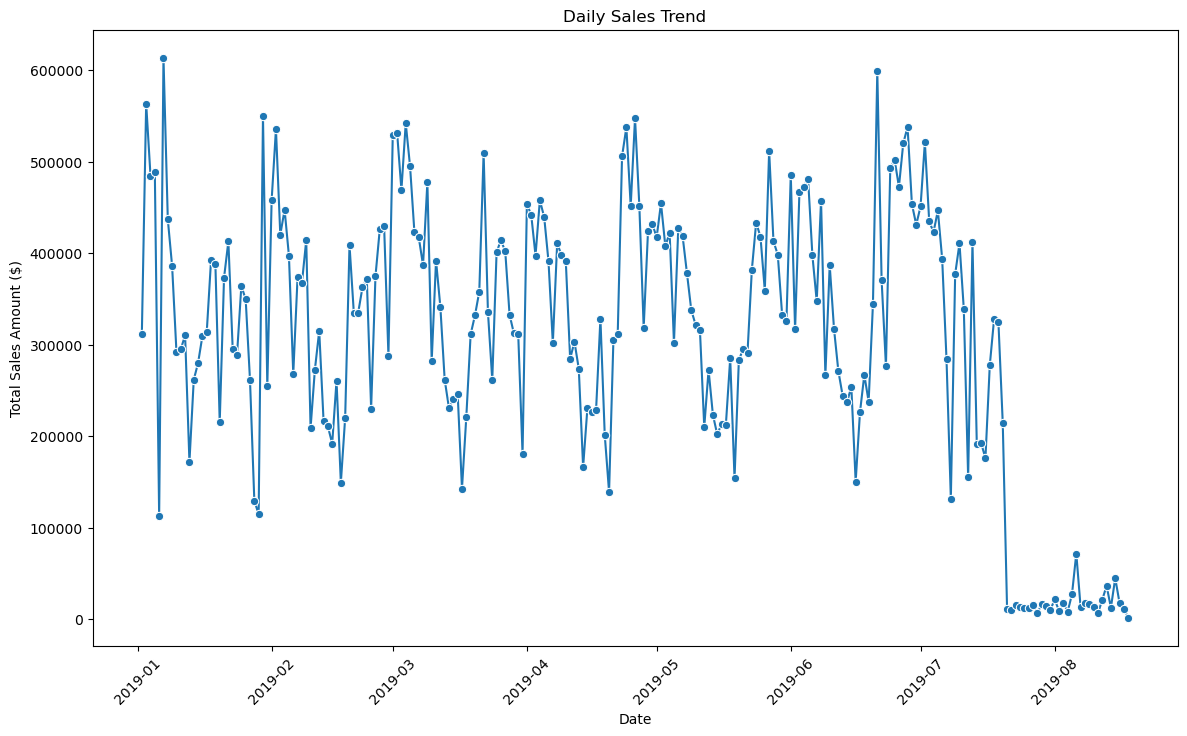

In [44]:
# 4. Similar aggregation by day
daily_sales = cable_prime.groupby('PaymentDate')['PaymentAmount'].sum().reset_index()

# Daily Sales Trend
plt.figure(figsize=(14, 8))
sns.lineplot(data=daily_sales, x='PaymentDate', y='PaymentAmount', marker='o', palette='coolwarm')
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount ($)')
plt.xticks(rotation=45)
plt.show()

### Sales Forecast for the Coming Year

In [46]:
# Register converters to avoid warning messages
register_matplotlib_converters()

# 1. Convert PaymentDate to datetime format if not already done
cable_prime['PaymentDate'] = pd.to_datetime(cable_prime['PaymentDate'], format='%Y%m%d')  # Adjust format if necessary

# Aggregate sales data by month
monthly_sales = cable_prime.groupby(pd.Grouper(key='PaymentDate', freq='M'))['PaymentAmount'].sum().reset_index()



In [47]:
# 2. Split the data into training and testing sets
train_size = int(len(monthly_sales) * 0.8)
train, test = monthly_sales[:train_size], monthly_sales[train_size:]

In [49]:
# 3. Fit the ARIMA model on the training set
# Differencing the series again
train['PaymentAmount_diff'] = train['PaymentAmount'].diff()
train = train.dropna()  # remove the row with the NaN value caused by differencing

# Fitting the model
model = ARIMA(train['PaymentAmount_diff'], order=(1, 0, 1))
model_fit = model.fit()

In [50]:
# 4. Make predictions
# Predicting on the test set
test['Predicted'] = model_fit.forecast(steps=len(test))

# Predicting for the coming year (next 12 months)
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=test['PaymentDate'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')


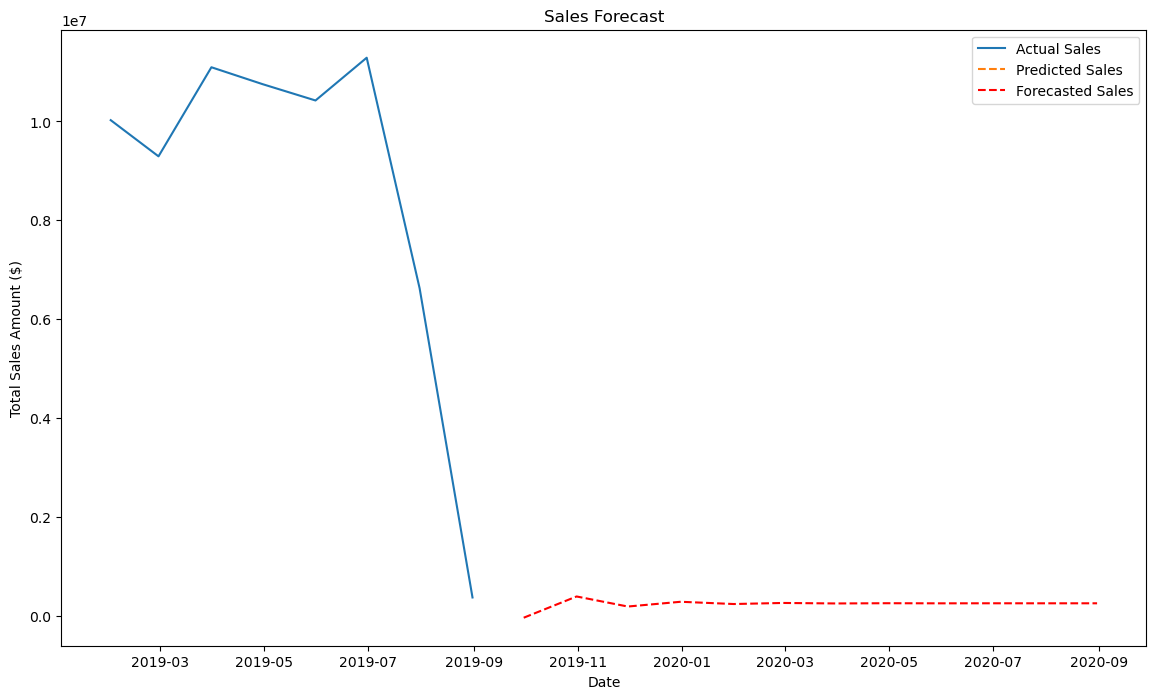

In [51]:
# 5. Visualize the forecast
plt.figure(figsize=(14, 8))
plt.plot(monthly_sales['PaymentDate'], monthly_sales['PaymentAmount'], label='Actual Sales')
plt.plot(test['PaymentDate'], test['Predicted'], label='Predicted Sales', linestyle='--')
plt.plot(forecast_dates, forecast, label='Forecasted Sales', linestyle='--', color='red')
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount ($)')
plt.legend()
plt.show()

In [57]:
# Print forecasted values for the next year
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Sales': forecast})
print("\nForecasted Sales for the Next Year:")
print(forecast_df)


Forecasted Sales for the Next Year:
         Date  Forecasted Sales
5  2020-01-01     -39170.165216
6  2020-02-01     390677.385552
7  2020-03-01     187251.895486
8  2020-04-01     283523.073336
9  2020-05-01     237962.707810
10 2020-06-01     259524.165281
11 2020-07-01     249320.198678
12 2020-08-01     254149.229117
13 2020-09-01     251863.888926
14 2020-10-01     252945.426898
15 2020-11-01     252433.588709
16 2020-12-01     252675.816295
